# Linear Least-Squares Algorithms for Temporal Difference Learning

### What is Linear Least Squares Temporal Difference Learning? 

 The linear least-squares function approximation aims to linearly estimate a function given pairwise samples of observed inputs and outputs.. Since we know that TD(0) with linear approximation converges asympotically to a fixed point, LSTD provides means to do this. It accomplishes this by building estimates of C matrix and d vector to directly solve for d + CBeta_{lambda} = 0 directly.
 

#Installing Pycolab and Gym

In [2]:
! pip install git+https://github.com/deepmind/pycolab.git
! pip install git+https://github.com/openai/gym.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-wOUldy-build
  Running setup.py install for pycolab ... - done
  Cloning https://github.com/openai/gym.git to /tmp/pip-LjVTYQ-build
    100% |████████████████████████████████| 1.0MB 928kB/s 
  Running setup.py install for gym ... - \ done


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import curses
import sys
import gym
import numpy as np
import time

from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites
import matplotlib.pyplot as plt

# Environment

## Common Environment Methods

In [0]:
def obsv2state(obs):
  """ Convert pycolab's observation to int state. 
      The state is flattened in our case and is (0,12).
  
      Args:
        obs: Pycolab's Observation object. 
        
      Returns:
        Integer state from (0,12). 
  """
  state = np.array(obs.layers['P'], dtype=np.float).flatten()
  states = np.flatnonzero(state)
  assert len(states) == 1, "There should be just one P."
  return states[0]

def displayenv(obs, display_visits=False, stored_chain=None):
  """ Display the environment from observation. 
      
      Args:
        obs: Pycolab's Observation object.
        display_visits: Whether to highlight the previously visited state.
        stored_chain: Previously stored values for the chain. This is used if displaying the old visits.
        
     Returns:
        Returns updated stored_chain to be used in next step to highlight previously visitied state.
  """
  
  chain = 125 * np.array(obs.layers['P'], dtype=np.float)  #The agent/player sprite P is indicated by 
  
  if display_visits:
    current_visits = 15.50 * np.array(obs.layers['P'], dtype=np.float)  #Indicates new visits to states
    
    if stored_chain is not None:
      stored_chain += current_visits
      chain += stored_chain                  #For visualization
    else:
      stored_chain = current_visits
    
  if 'G' in obs.layers:
    chain += 175 * np.array(obs.layers['G'], dtype=np.float)     #Indicates Goal distinctly

  plt.figure(figsize=(3,4))
  plt.axis('off')
  plt.imshow(chain, cmap='Reds')
 
    
  return stored_chain

## Boyan's Chain 

In [0]:
# --------------------------13-State Markov Chain From Boyan----------------------------------#
BOYANCHAIN_STATES = ['P           G']


# --------------------------Features for Boyan Chain------------------------------------------#
# For value function approximation, each state is represented by four features, as follows: 
# the representations for states 12, 8, 4, and 0 are, respectively, [1, 0, 0, 0], [0, 1, 0, 0],
# [0, 0, 1, 0], and [0, 0, 0, 1]; and the representations for the other states are obtained by 
# linearly interpolating between these.
# --------------------------------------------------------------------------------------------#
BOYANCHAIN_FEATURES = np.array([[1.00, 0.00, 0.00, 0.00],
                                [0.75, 0.25, 0.00, 0.00],
                                [0.50, 0.50, 0.00, 0.00],
                                [0.25, 0.75, 0.00, 0.00],
                                [0.00, 1.00, 0.00, 0.00],
                                [0.00, 0.75, 0.25, 0.00],
                                [0.00, 0.50, 0.50, 0.00],
                                [0.00, 0.25, 0.75, 0.00],
                                [0.00, 0.00, 1.00, 0.00],
                                [0.00, 0.00, 0.75, 0.25],
                                [0.00, 0.00, 0.50, 0.50],
                                [0.00, 0.00, 0.25, 0.75],
                                [0.00, 0.00, 0.00, 0.00]])

class PlayerSpriteBoyanChain(prefab_sprites.MazeWalker):
  """A `Sprite` for our player."""

  def __init__(self, corner, position, character):
    """Inform superclass that we cant walk through #."""
    super(PlayerSpriteBoyanChain, self).__init__(
        corner, position, character, impassable='#')
    
  def update(self, actions, board, layers, backdrop, things, the_plot):
    del backdrop, things   # Unused.
    
    #Get current position in the chain
    info, position = self.position

    # Apply motion commands.
    if actions == 0:    # Only one action ==> left to right.
      if layers["G"][0, position+1]:     # If current state is just adjacent to the goal state Reward = -2
        self._east(board, the_plot)
        the_plot.add_reward(-2)
      else:                              # From any other 11 states, not adjacent to goal or goal Reward = -3
        if (np.random.rand() > 0.5):
          self._east(board, the_plot)
          self._east(board, the_plot)
        else:
          self._east(board, the_plot)
        the_plot.add_reward(-3) 

    if layers["G"][self.position]:     # If current state is Goal State, Terminate Episode
      the_plot.terminate_episode()


class BoyansChain(gym.Env):
  def __init__(self):
    self.game= ascii_art.ascii_art_to_game(
                  BOYANCHAIN_STATES, 
                  what_lies_beneath=' ',
                  sprites={'P': PlayerSpriteBoyanChain})
    
    obs, reward, gamma = self.game.its_showtime()

  def step(self):
    """ Take given action and return the next state observation and reward.
    """
    obs, reward, gamma = self.game.play(0)
    return obs, reward, self.game.game_over, ""
  
  
  def reset(self):
    """ Resets the game and returns the observation for the start state.
    """
    self.game= ascii_art.ascii_art_to_game(
                  BOYANCHAIN_STATES, 
                  what_lies_beneath=' ',
                  sprites={'P': PlayerSpriteBoyanChain})
    obs, reward, gamma = self.game.its_showtime()
    return obs


**Testing Boyan Chain Environment**

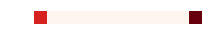

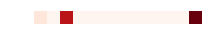

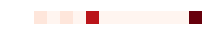

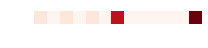

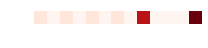

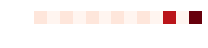

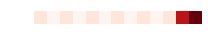

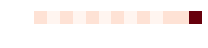

In [66]:
game = BoyansChain()
obs = game.reset()
stored_chain = displayenv(obs, display_visits=True)
returnGt = 0

game_over = False

#Play until terminates
while not(game_over):
  obs, reward, game_over, _ = game.step()
  returnGt += reward
  stored_chain = displayenv(obs, display_visits=True, stored_chain=stored_chain)

## Bradtke & Barto

In [0]:
# --------------------------5-State Markov Chain From Bradtke----------------------------------#
BRADTKE_STATES = ['P    ']


# --------------------------Transition probabilities, reward matrix and features for Bradtke Chain -------#

TRANSITION_MATRIX = np.array([[0.42, 0.13, 0.14, 0.03, 0.28],
                              [0.25, 0.08, 0.16, 0.35, 0.15],
                              [0.08, 0.20, 0.33, 0.17, 0.22],
                              [0.36, 0.05, 0.00, 0.51, 0.07],
                              [0.17, 0.24, 0.19, 0.18, 0.22]])

REWARD_MATRIX = np.array([[104.66, 29.69,  82.36,  37.49, 68.82],
                          [ 75.86, 29.24, 100.37,   0.31, 35.99],
                          [ 57.68, 65.66,  56.95, 100.44, 47.63],
                          [ 96.23, 14.01,   0.88,  89.77, 66.77],
                          [ 70.35, 23.69,  73.41,  70.70, 85.41]])

BRADTKE_FEATURE_MATRIX = np.array([[74.29, 34.61, 73.48, 53.29,  7.79],
                                   [61.60, 48.07, 34.68, 36.19, 82.02],
                                   [97.00,  4.88,  8.51, 87.89,  5.17],
                                   [41.10, 40.13, 64.63, 92.67, 31.09],
                                   [ 7.76, 79.82, 43.78,  8.56, 61.11]])


class PlayerSpriteBradtkeChain(prefab_sprites.MazeWalker):
  """A `Sprite` for our player."""

  def __init__(self, corner, position, character):
    """Inform superclass that we cant walk through #."""
    super(PlayerSpriteBradtkeChain, self).__init__(
        corner, position, character, impassable='#')
    
  def update(self, actions, board, layers, backdrop, things, the_plot):
    del backdrop, things   # Unused.
    
    #Get current position in the chain
    info, position = self.position

    # Apply motion commands.
    if actions == 0:    
      
      # Choose next state for the current state randomly. 
      new_position = np.argmax(np.random.multinomial(n=1, pvals=TRANSITION_MATRIX[position, :]))
      
      # Get the next reward from next and current state.
      the_plot.add_reward(REWARD_MATRIX[position, new_position])
      
      # Move to next state.
      self._teleport((0, new_position))

class BradtkeChain(gym.Env):
  def __init__(self):
    self.game= ascii_art.ascii_art_to_game(
                  BRADTKE_STATES, 
                  what_lies_beneath=' ',
                  sprites={'P': PlayerSpriteBradtkeChain})
    
    obs, reward, gamma = self.game.its_showtime()
  
  def step(self):
    """ Take given action and return the next state observation and reward.
    """
    obs, reward, gamma = self.game.play(0)
    return obs, reward, self.game.game_over, ""
  
  
  def reset(self):
    """ Resets the game and returns the observation for the start state.
    """
    self.game= ascii_art.ascii_art_to_game(
                  BRADTKE_STATES, 
                  what_lies_beneath=' ',
                  sprites={'P': PlayerSpriteBradtkeChain})
    
    obs, reward, gamma = self.game.its_showtime()
    return obs


**Testing Five States Environment**

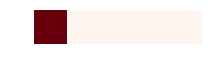

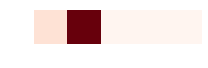

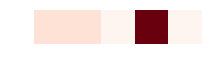

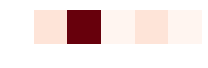

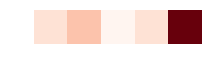

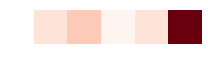

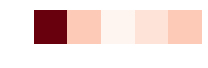

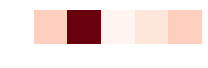

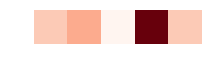

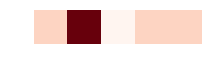

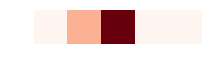

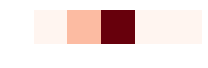

In [83]:
game = BradtkeChain()
obs = game.reset()
stored_chain = displayenv(obs, display_visits=True)
returnGt = 0

game_over = False

max_steps = 10

step = 0

#Play until terminates
while not(game_over):
  obs, reward, game_over, _ = game.step()
  returnGt += reward
  storedchain = displayenv(obs, display_visits=True, stored_chain=stored_chain)
  step += 1
  
  if step > max_steps:
    break
    

# LSTD(lamda)

***Offline LSTD Implementation***

In [0]:
#--------------------------------------------------------------------
# 
# Given: simulation model, featurizer, and \lambda for TD($\lambda$)
# Output: a coefficient vector Beta for which Vpi(x) = Beta . Phi(x)
#
#
#
#--------------------------------------------------------------------

def offlineLSTD(game, featurizer, lstd_gamma, lstd_lambda, episodes=1000, max_timesteps=1000):
  A, b = 0, 0
  betas = []
  
  for n in range(episodes):
    
    #Choose a start state xt E X
    obs = game.reset()
    state = obsv2state(obs)
    game_over = False
    
    #Set eligibility trace vector Zt = Featurizer(xt)
    phi_t = featurizer[state]
    traces = phi_t

    timesteps = 0
    
    #While xt != End, Repeat:
    while not(game_over) and timesteps < max_timesteps:
      #Simulate on step of the chain, producing a reward Rt and next state xt+1
      obs, reward, game_over, _ = game.step()
      next_state = obsv2state(obs)
                  
      phi_tp = featurizer[next_state]

      A = A + np.outer(traces, phi_t - lstd_gamma * phi_tp)

      b = b + traces * reward  # b = b + eligibility * reward

      traces = lstd_gamma * lstd_lambda * traces + phi_tp # Set $Z_t+1 = \lambda * Z_t + phi(x_t+1)

      timesteps = timesteps + 1
      phi_t = phi_tp
    
    #Whenever updated coefficients are desired: Set Beta = Ainv.b
    beta = np.dot(np.linalg.inv(A),b)
    betas.append(beta)  
    
  return A, b, np.array(betas)

***Recursive LSTD Implementation***

In [0]:
#--------------------------------------------------------------------
# 
# Given: simulation model, featurizer, and \lambda for TD($\lambda$)
# Output: a coefficient vector Beta for which Vpi(x) = Beta . Phi(x)
#
#
#
#--------------------------------------------------------------------

def recursiveLSTD(game, featurizer, lstd_gamma, lstd_lambda, episodes=1000, max_timesteps=1000, init_eps=10e-10):
  Ainv = np.eye(featurizer.shape[1]) * 1/init_eps
  b = np.zeros(featurizer.shape[1]) 

  betas = []
  for n in range(episodes):    
    #Choose a start state xt E X
    obs = game.reset()
    state = obsv2state(obs)
    #storedchain = displayenv(obs, displayvisits=True)

    #Set eligibility trace vector Zt = Featurizer(xt)
    phi_t = featurizer[state].reshape(-1,1)
    traces = phi_t

    timesteps = 0
    
    #While xt != End, Repeat:
    game_over = False
    while not(game_over) and timesteps < max_timesteps:
      #Simulate on step of the chain, producing a reward Rt and next state xt+1
      obs, reward, game_over, _ = game.step()
      next_state = obsv2state(obs)
      phi_tp = featurizer[next_state].reshape(-1,1)
      
      
      u = traces
      v = (phi_t - lstd_gamma * phi_tp)
      
      Ainv = Ainv - np.dot(Ainv, np.dot(np.dot(u, v.T), Ainv))/(1 + np.dot(v.T, np.dot(Ainv, u))) 

      b = b + traces.reshape(-1) * reward  #b = b + eligibility * reward

      traces = lstd_gamma * lstd_lambda * traces + phi_tp #Set $Z_t+1 = \lambda * Z_t + phi(x_t+1)
      
      timesteps = timesteps + 1
     
      phi_t = phi_tp

    #Whenever updated coefficients are desired: Set Beta = Ainv.b
    beta = np.dot(Ainv,b)
    betas.append(beta)
    
  return Ainv, b, np.array(betas)

# Empirical Analysis 

## Boyan's Chain: Performance of Offline LSTD for Different Lambda Values

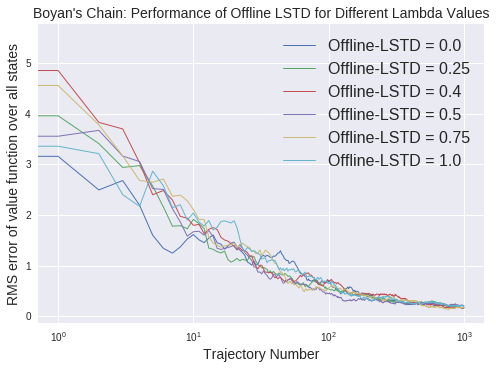

In [105]:
#-------------------------------------------------------------------------------------------#
#---RMSE Comparison of different lambdas for Boyan Chain using Offline LSTD (OLSTD)---------#
#-------------------------------------------------------------------------------------------#

lambdas = [0.00, 0.25, 0.40, 0.50, 0.75, 1.00]
trials  = 10
episodes = 1000
lstd_gamma = 1.00
size = (len(lambdas), episodes)

#In fact, this domain’s optimal V π function is exactly linear in these features: the optimal coefficients β∗λ are (−24, −16, −8, 0).
beta_Optimal = np.array([-24, -16, -8, 0])

game = BoyansChain()
featurizer = BOYANCHAIN_FEATURES
V_Optimal = np.dot(beta_Optimal, BOYANCHAIN_FEATURES.T)

errors = np.zeros(size)
legends = []
total_time = 0
for i,lambda_current in enumerate(lambdas):
  for _ in range(trials):    
    _, _, betas = offlineLSTD(game, featurizer, lstd_gamma, lambda_current, episodes)
    predicted_Vs = np.dot(betas, BOYANCHAIN_FEATURES.T)
    errors[i] += np.linalg.norm(predicted_Vs - V_Optimal, axis=1)
  errors[i] /= trials
  legend = "Offline-LSTD = {:}".format(lambda_current)
  legends.append(legend)
  plt.semilogx(range(episodes), errors[i], linewidth=1)

plt.xlabel("Trajectory Number", fontsize=14)
plt.ylabel("RMS error of value function over all states", fontsize=14)
plt.title("Boyan's Chain: Performance of Offline LSTD for Different Lambda Values", fontsize=14)
plt.legend(legends, prop={'size': 16}, loc='upper right', fancybox=True, framealpha=0.5)
plt.show()


## Boyan's Chain: Performance of Recursive LSTD for Different Lambda Values

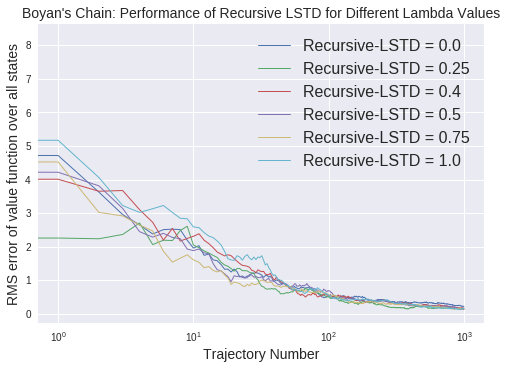

In [106]:
#-------------------------------------------------------------------------------------------#
#---RMSE Comparison of different lambdas for Boyan Chain using Recursive LSTD (OLSTD)-------#
#-------------------------------------------------------------------------------------------#

lambdas = [0.00, 0.25, 0.40, 0.50, 0.75, 1.00]
trials  = 10
episodes = 1000
lstd_gamma = 1.00
size = (len(lambdas), episodes)


#In fact, this domain’s optimal V π function is exactly linear in these features: the optimal coefficients β∗λ are (−24, −16, −8, 0).
beta_Optimal = [-24, -16, -8, 0]
game = BoyansChain()
featurizer = BOYANCHAIN_FEATURES
V_Optimal = np.dot(beta_Optimal, BOYANCHAIN_FEATURES.T)

errors = np.zeros(size)
legends = []
for i,lambda_current in enumerate(lambdas):
  for _ in range(trials):
    _, _, betas = recursiveLSTD(game, featurizer, lstd_gamma, lambda_current, episodes)
    predicted_Vs = np.dot(betas, BOYANCHAIN_FEATURES.T)
    errors[i] += np.linalg.norm(predicted_Vs - V_Optimal, axis=1)
  errors[i] /= trials
  legend = "Recursive-LSTD = {:}".format(lambda_current)
  legends.append(legend)
  plt.semilogx(range(episodes), errors[i], linewidth=1)

plt.xlabel("Trajectory Number", fontsize=14)
plt.ylabel("RMS error of value function over all states", fontsize=14)
plt.title("Boyan's Chain: Performance of Recursive LSTD for Different Lambda Values", fontsize=14)
plt.legend(legends, prop={'size': 16}, loc='upper right', fancybox=True, framealpha=0.5)
plt.show()



## Bradtke Chain: Performance of Offline LSTD for Different Lambda Values

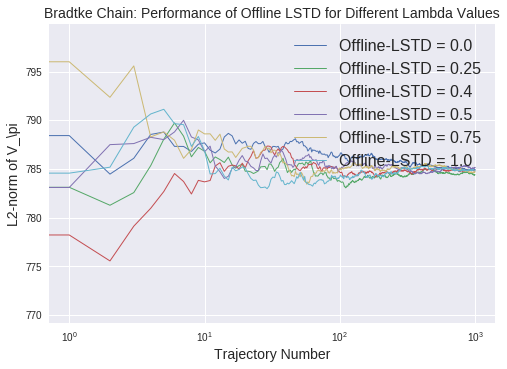

In [93]:
#-------------------------------------------------------------------------------------------#
#---RMSE Comparison of different lambdas for Bradtke Chain using Offline LSTD (OLSTD)-------#
#-------------------------------------------------------------------------------------------#

lambdas = [0.00, 0.25, 0.40, 0.50, 0.75, 1.00]
trials  = 10
episodes = 1000
lstd_gamma = 0.8
size = (len(lambdas),episodes)
max_timesteps = 100

#In fact, this domain’s optimal V π function is exactly linear in these features: the optimal coefficients β∗λ are (−24, −16, −8, 0).
game = BradtkeChain()
featurizer = BRADTKE_FEATURE_MATRIX
V_Optimal = np.dot(beta_optimal_bradtke, BRADTKE_FEATURE_MATRIX.T)

errors = np.zeros(size)
legends = []
for i,lambdacurrent in enumerate(lambdas):
  for _ in range(10):
    _, _, betas = offlineLSTD(game, featurizer, lstd_gamma, lambdacurrent, episodes, max_timesteps)
    predicted_Vs = np.dot(betas, BRADTKE_FEATURE_MATRIX.T)
    
    errors[i] += np.linalg.norm(predicted_Vs, axis=1)
  errors[i] /= trials
  legend = "Offline-LSTD = {:}".format(lambdacurrent)
  legends.append(legend)
  plt.semilogx(range(episodes), errors[i], linewidth=1)

plt.xlabel("Trajectory Number", fontsize=14)
plt.ylabel("L2-norm of V_\pi", fontsize=14)
plt.title("Bradtke Chain: Performance of Offline LSTD for Different Lambda Values", fontsize=14)
plt.legend(legends, prop={'size': 16}, loc='upper right', fancybox=True, framealpha=0.5)
plt.show()


## Bradtke Chain: Performance of Recursive LSTD for Different Lambda Values

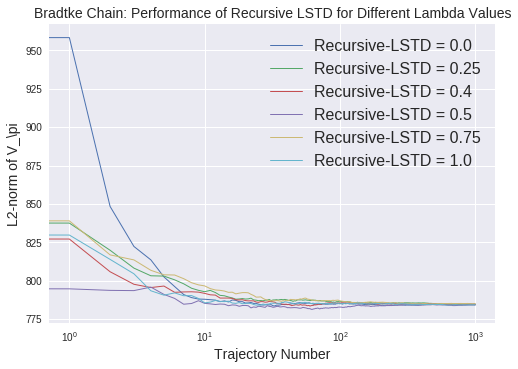

In [97]:
#-------------------------------------------------------------------------------------------#
#---RMSE Comparison of different lambdas for Bradtke Chain using Recursive LSTD (RLSTD)-------#
#-------------------------------------------------------------------------------------------#

lambdas = [0.00, 0.25, 0.40, 0.50, 0.75, 1.00]
trials  = 10
episodes = 1000
lstd_gamma = 0.8
size = (len(lambdas),episodes)
max_timesteps = 100

#In fact, this domain’s optimal V π function is exactly linear in these features: the optimal coefficients β∗λ are (−24, −16, −8, 0).
game = BradtkeChain()
featurizer = BRADTKE_FEATURE_MATRIX

errors = np.zeros(size)
legends = []
for i,lambda_current in enumerate(lambdas):
  for _ in range(10):
    _, _, betas = recursiveLSTD(game, featurizer, lstd_gamma, lambda_current, episodes, max_timesteps)
    predicted_Vs = np.dot(betas, BRADTKE_FEATURE_MATRIX.T)
    
    errors[i] += np.linalg.norm(predicted_Vs, axis=1)
  errors[i] /= trials
  legend = "Recursive-LSTD = {:}".format(lambda_current)
  legends.append(legend)
  plt.semilogx(range(episodes), errors[i], linewidth=1)

plt.xlabel("Trajectory Number", fontsize=14)
plt.ylabel("L2-norm of V_\pi", fontsize=14)
plt.title("Bradtke Chain: Performance of Recursive LSTD for Different Lambda Values", fontsize=14)
plt.legend(legends, prop={'size': 16}, loc='upper right', fancybox=True, framealpha=0.5)
plt.show()


## Discussion

In this set of experiments we evaluated our implementation of Offline-LSTD and Recursive-LSTD on two set of environments: Boyan's chain from [1] and Bradtke's chain from [2]. We ran each of these for 1000 episodes. As Bradtke's chain doesn't have a terminal state, we ran Bradtke's chain for 100 steps. $\gamma$ for Boyan's chain was set to $1$ and for Bradtke's chain to $0.8$. 

As we knew the optimal value for Boyan's chain, we plotted the RMSE over episodes for these experiments. We see that for all values of $\lambda$ the RMSE quickly coverges to $0$. So, the choice of $\lambda$ doesn't have much impact of either Offline or Recursive LSTD algorithm.

For Bradtke's chain, we plotted the L2-norm of $V_\pi$. We see the same behavior that $V_pi$ coverges to same value for all values of $\lambda$ almost at the same rate i.e. the value of $\lambda$ doesn't have much impact of convergence. We choose $\gamma=0.8$ randomly and didn't run our experiments for various values of $\gamma$

[1] Bradtke, Steven J., and Andrew G. Barto. "Linear least-squares algorithms for temporal difference learning." Machine learning 22.1-3 (1996): 33-57.

[2] Boyan, Justin A. "Technical update: Least-squares temporal difference learning." Machine Learning 49.2-3 (2002): 233-246.

## Equivalence of LSTD(1) and linear regression

**Read the section “Equivalence of LSTD(1) and linear regression” in the appendix of Boyan’s paper. Verify this claim empirically by computing the matrices A and b in the “supervised learning” approach. Compare the matrices with those that you would have obtained by LSTD(lambda=1) in part 1 and 2. Check if the solution (value function) found by the “supervised learning” approach matches the solution found by LSTD.**

In [0]:
def build_features_returns(game, featurizer, episodes=1000):
  features = []
  returns = []
  
  for n in range(episodes):
    feats = []
    rewards = []
    game_over = False

    #Choose a start state xt E X
    obs = game.reset()
    state = obsv2state(obs)
    
    #While xt != End, Repeat:
    while not(game_over):
      #Simulate on step of the chain, producing a reward Rt and next state xt+1
      
      feats.append(featurizer[state])

      obs, reward, game_over, _ = game.step()
      next_state = obsv2state(obs)
     
      rewards.append(reward)
      
      state = next_state

    features.extend(feats)
    returns.extend([np.sum(rewards[t:]) for t in range(len(rewards))])
  
  return np.array(features), np.array(returns) 
  

In [96]:
game = BoyansChain()
lstd_lambda = 1
lstd_gamma = 1
featurizer = BOYANCHAIN_FEATURES
episodes = 1000
errors = np.zeros(episodes)

np.random.seed(2204)
Phi, Y = build_features_returns(game, featurizer, episodes)

# A = X^TX
A_lsq = np.dot(Phi.T, Phi)

# b = X^TY
b_lsq = np.dot(Phi.T, Y)

# W = A^{-1}b
Beta_lsq = np.dot(np.linalg.inv(A_lsq),b_lsq) 

print('_' * 100)
print("Ainv, b, beta and V_pi for Linear Least Square Regression")
print('_' * 100)

print(np.linalg.inv(A_lsq))
print('-' * 50)
print(b_lsq)
print('-' * 50)
print(Beta_lsq)
print('-' * 50)
print(np.dot(Beta_lsq, BOYANCHAIN13STATES_FEATURES.T))


np.random.seed(2204)
A_olstd, b_olstd, Beta_olstd = offlineLSTD(game, featurizer, lstd_gamma, lstd_lambda, episodes)

print('\n')
print('_' * 100)
print("Ainv, b, beta and V_pi for Offline LSTD for \lambda=1")
print('_' * 100);

print(np.linalg.inv(A_olstd))
print('-' * 50)
print(b_olstd)
print('-' * 50)
print(Beta_olstd[-1])
print('-' * 50)
print(np.dot(Beta_olstd[-1], BOYANCHAIN13STATES_FEATURES.T))


np.random.seed(2204)
Ainv_rlstd, b_rlstd, Beta_rlstd = recursiveLSTD(game, featurizer, lstd_gamma, lstd_lambda, episodes)

print('\n')
print('_' * 100)
print("Ainv, b, beta and V_pi for Recursive LSTD for \lambda=1")
print('_' * 100);

print(Ainv_rlstd)
print('-' * 50)
print(b_rlstd)
print('-' * 50)
print(Beta_rlstd[-1])
print('-' * 50)
print(np.dot(Beta_rlstd[-1], BOYANCHAIN13STATES_FEATURES.T))



____________________________________________________________________________________________________
Ainv, b, beta and V_pi for Linear Least Square Regression
____________________________________________________________________________________________________
[[ 7.05203281e-04 -1.64489145e-04  4.47292782e-05 -3.20586085e-05]
 [-1.64489145e-04  6.23964394e-04 -1.69673670e-04  1.21609424e-04]
 [ 4.47292782e-05 -1.69673670e-04  6.95326683e-04 -4.98358275e-04]
 [-3.20586085e-05  1.21609424e-04 -4.98358275e-04  2.06494565e-03]]
--------------------------------------------------
[-42652.5  -42186.   -21500.75  -3363.75]
--------------------------------------------------
[-2.39934198e+01 -1.60676412e+01 -8.02365462e+00  6.28036668e-03]
--------------------------------------------------
[-23.99341976 -22.01197512 -20.03053048 -18.04908584 -16.0676412
 -14.05664455 -12.04564791 -10.03465126  -8.02365462  -6.01617087
  -4.00868713  -2.00120338   0.        ]


____________________________________

### Discussion 

**Equivalence of LSTD(1) and linear regression**

In this set of experiments, we aim to prove that for $\lambda=1$, the LSTD($\lambda$) algorithm is equivalent to Linear Least Square Regression. We empirically show that for Boyan's chain, the $A$ ($Ainv$), $b$, $\beta$ and $V_\pi$ for Offline-LSTD($\lambda$), Recursive-LSTD($\lambda$) and Least Square Linear Regression converge to the same value. 

We achieved this by first building the dataset for linear least square regression as mentioned in Appendix of Boyan's paper. The features $\Phi$ (Phi) and returns $Y$ (cumulated rewards) were built by running to game for $episode$=1000 number of times. Then using these features and returns, we do Linear Least Square update to compute $\beta$. $A$ and $b$ were the byproducts of this computations. 

Similarly, for both Recursive as well as Offline LSTD($\lambda$), we ran the experiments $episodes$=1000. We also retured the $A$ ($Ainv$ in case of recursive) and $b$ from our lstd methods. 
